<div class="alert alert-info"> 
<h3>TASK</h3>
<br>
An A/B test from an international online store was launched and left unfinished. The person in charged quit and left only the technical specifications and the test results.<b>I was assigned to check if the A/B test was carried out correctly and to analyze the results.</b>
<br>   
<br>According to the planned sample size and expected outcome as improvement in 14 days conversion rate, this was expected to be a frequentist A/B test.
<br>
<br><b>There were some uncertainties regarding the quality of the test: two different test names, heavily unbalanced groups and mixed group users.</b> <a href="#part_1b">[Part_1b Check A/B Test Technical Specification]</a>
</div>

<div class="alert alert-warning"> 
<h3>APPROACH</h3>
<br>
Despite the uncertainties, both two tests were analyzed separately. 
<br>
<br><b>With careful timeline consideration, conversion time limit were adjusted to 7days instead of the originally planned 14 days.</b> <a href="#part_2">[Part_2 Exploratory Data Analysis]</a>
</div>

<div class="alert alert-success"> 
<h3>RESULT</h3>
<br>
<b>The case could finally be closed even though no significant improvement in conversion rate was detected in group B of both tests.</b> <a href="#part_3">[Part_3 Analyze A/B Test REsuts]</a>
</div>

# PROJECT: A/B Test - Improved Recommendation System (EU)

### AIM: Check if A/B test was performed correctly and analyse results  

    
### TABLE OF CONTENT:

* [PART_1> Data Overview and Preparation](#part_1)  
    + [Overview and Preprocessing](#part_1a)
    + [Check A/B Test Technical Specification](#part_1b)

* [PART_2> Exploratory Data Analysis](#part_2) 

* [PART_3> Analyze A/B Test Results](#part_3) 

* [PART_4> Summary and Conclusion](#part_4) 

---
---

In [1]:
# IMPORT PACKAGES USED FOR PROJECT-------------------------------------------------#
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

# GENERAL SETUP -------------------------------------------------------------------#
path = '/datasets/'
os.chdir(path)

# LIST OF FUNCTIONS USED FOR PROJECT-----------------------------------------------#

def Breakline(n=100):
    """
    Draw breakline
    """
    print()
    print('-'*n)
    print()


def NaN_Columns(df):
    """
    Get list of dataframe columns containing missing data
    """
    return df.columns[df.isnull().any()].tolist()



def Subset_Size(df, cond, unique=None):
    """
    Compare size of subset and original dataframe
    + cond: indexing condition
    + unique: compare number nunique values
    """
    try:
        if unique:
            return(str(df[cond][unique].nunique()) + ' ({:.1%})'.format(df[cond][unique].nunique()/df[unique].nunique()))
        
        else:
            return(str(len(df[cond])) + ' ({:.2%})'.format(len(df[cond])/len(df)))
    except:
        return ('Error')


def Check_Unique(df, col1, col2, report=True, normalize=False):
    """
    Use to check for 1-1 or 1-multi relationship between 2 category variables
    => identify col1 value that have unique or multiple coresponding col2 values in dataframe df
    """
    count = df.groupby(col1)[col2].nunique()
    if report:
        table = count.value_counts(normalize=normalize).reset_index().sort_values('index')
        if normalize:
            table.columns = [col2 + ' nunique', col1 + ' proportion']
        else:
            table.columns = [col2 + ' nunique', col1 + ' count']
        display(table)
    return count


def Pivot_Columns_Percentage (df, index, column, value, aggfunc):
    """
    Convert normal pivot_table values to percentages for each columns
    """
    table = df.pivot_table(index=index, columns= column, values=value, aggfunc=aggfunc)
    total = table.sum(axis=1)
    for col in table.columns:
        table[col] = table[col]/total
    return table


def Proportion_Ztest (success, trial):
    """
    Statistic Ztest calculation
    """
    import math
    import scipy.stats as st

    p1 = success[0]/trial[0] 
    p2 = success[1]/trial[1]
    p_combined = (success[0] + success[1]) / (trial[0] + trial[1])
    
    z_value = (p1-p2) / math.sqrt(p_combined * (1 - p_combined) * (1/trial[0] + 1/trial[1]))

    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    rel_diff = (p2-p1)/p1
    return {'pvalue':p_value, 'zvalue': z_value, 'rdiff': rel_diff, 'p1':p1, 'p2':p2}


def ABTest_Analysis (test, lastdate, delta, alpha=0.05):
    """
    A/B TEST ANALYSIS REPORT USED FOR THIS PROJECT ONLY
    + filter dataframe and calculate binary conversion within "delta" days for each users
    + calculate conversion rate and bar plot
    + hypothesis and statistic conclusion with lastest pvalue and "alpha" level
    """
    print('_'*10,'COMPARE {}-DAYS CONVERSION BETWEEN A/B GROUPS OF "{}"'.format(delta, test.upper()), '_'*10)
    print()
    # choose specific users
    users = df[(df['user_id'].isin(chosen_id))
        & (df['first_date']<=(lastdate - np.timedelta64(delta,'D')))
        & (df['ab_test']==test)].reindex()

    # check "events" df to see if user converted within limit days (calculate for each stage)
    converted = events.groupby(['user_id','event_name']).apply(lambda row: 1 if ((row['event_dt'] - row['first_date']).min().days <= delta) else 0).unstack(1)#.rename(event).reset_index()


    users = users.merge(converted, on='user_id', how='left') # merge "converted" to users df    
    users[event_list] = users[event_list].fillna(0).astype('int64') # set non converted as 0

    # BAR PLOT CONVERSION RATE
    ax = users[users['ab_test']==test].groupby('group')[event_list].agg(lambda x: x.sum()/x.count()).T.plot.bar(rot=0, title=test.upper(), ylabel=str(delta)+'-days Conversion Rate')
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x(), p.get_height() + 0.01))
    plt.show()

    # STATISTIC Z-TEST REPORT
    print('* With alpha level', alpha,':')
    print()
    test = users[users['ab_test']==test].groupby('group')[event_list].agg(['sum','count'])
    for event in event_list[1:]:
        pvalue = Proportion_Ztest(test[event]['sum'], test[event]['count'])['pvalue']
        if pvalue<alpha:
            test_result = [pvalue,'', 'are different']
        else:
            test_result = [pvalue,'not', 'could be the same']
        print('"{}" STAGE - pvalue {:.4f}: We can {} reject H0 hypothesis, the {}-days conversion rate of 2 groups {}.'.format(event.upper(), test_result[0], test_result[1], delta, test_result[2]))


# Part_1> DATA OVERVIEW AND PREPARATION <a id="part_1"></a>

## Overview and Preprocessing  <a id="part_1a"></a>

### SUMMARY:

4 datasets are provided:
+ "campaign" : list of marketing events for 2020 which can affect the A/B test if overlapped in time.   

+ "users" : unique records of new `user_id` - `first_date` - `region` - `device` for first signed up   

+ "events" : activity records of user as `event_dt` and `event_name` (additional `details` have missing data but are not importance for conversion A/B test result analysis)   

+ "test" : information of participated in `ab_test` name and `group` for ~14000 users.   

There are **recommender_system_test** and **interface_eu_test** with ~900 mixed_test users (non uniform group assignment)  
=> The tests have to be analysed seperately.

In [2]:
filename = {
    'campaign'  : 'ab_project_marketing_events_us.csv',
    'users'     : 'final_ab_new_users_upd_us.csv',
    'events'    : 'final_ab_events_upd_us.csv',
    'test'      : 'final_ab_participants_upd_us.csv'
}

dfs = {}
for key in filename.keys():
    print('OVERVIEW "{}"" DATAFRAME ({})'.format(key.upper(), filename[key]))
    print()

    dfs[key] = pd.read_csv(filename[key])

    print('+ Columns with missing data:', NaN_Columns(dfs[key]))
    print('+ Number of duplicated rows:', Subset_Size(dfs[key], dfs[key].duplicated()))
    print()

    print(dfs[key].info()) #general information
    display(dfs[key].drop(dfs[key].index[5:-5])) #first and last 5 rows

    Breakline()

OVERVIEW "CAMPAIGN"" DATAFRAME (ab_project_marketing_events_us.csv)

+ Columns with missing data: []
+ Number of duplicated rows: 0 (0.00%)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07



----------------------------------------------------------------------------------------------------

OVERVIEW "USERS"" DATAFRAME (final_ab_new_users_upd_us.csv)

+ Columns with missing data: []
+ Number of duplicated rows: 0 (0.00%)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone
58702,8F04273BB2860229,2020-12-20,EU,Android



----------------------------------------------------------------------------------------------------

OVERVIEW "EVENTS"" DATAFRAME (final_ab_events_upd_us.csv)

+ Columns with missing data: ['details']
+ Number of duplicated rows: 0 (0.00%)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
None


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN
423760,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN



----------------------------------------------------------------------------------------------------

OVERVIEW "TEST"" DATAFRAME (final_ab_participants_upd_us.csv)

+ Columns with missing data: []
+ Number of duplicated rows: 0 (0.00%)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test
14524,79F9ABFB029CF724,B,interface_eu_test



----------------------------------------------------------------------------------------------------



In [3]:
# change to datetime data all "_dt" and "_date" columns
for df in dfs.keys():
    for col in dfs[df].columns:
        if ('_dt' in col) | ('_date' in col):
            dfs[df][col] = pd.to_datetime(dfs[df][col])

# Compare number of records and users in "users" and "test" dataframe
for df in ['users','test']:
    print('Number of duplicated "user_id" in "{}" dataframe: {}'.format(df, sum(dfs[df].duplicated('user_id'))))
    print()

Breakline()

print('CHECK "TEST" DATAFRAME')
print()

check={}
for col in ['ab_test', 'group']: # check for mixed test and group users
    print('+ Unique "{}": {}'.format(col, dfs['test'][col].unique()))
    print('Number of participated "{}" for each user'.format(col))
    check[col] = Check_Unique(dfs['test'],'user_id',col)
    print()

mixed_test_users = check['ab_test'].index[check['ab_test']>1].tolist() #get list of mixed test users

Number of duplicated "user_id" in "users" dataframe: 0

Number of duplicated "user_id" in "test" dataframe: 887


----------------------------------------------------------------------------------------------------

CHECK "TEST" DATAFRAME

+ Unique "ab_test": ['recommender_system_test' 'interface_eu_test']
Number of participated "ab_test" for each user


,ab_test nunique,user_id count
0,1,12751
1,2,887



+ Unique "group": ['A' 'B']
Number of participated "group" for each user


,group nunique,user_id count
0,1,13197
1,2,441


## Check A/B Test Technical Specification <a id="part_1b"></a>

### SUMMARY:

**Expected test information:**
+ Test name: `recommender_system_test`  
+ 6000 new user from EU `region` with `first_date` from '2020-12-07' until '2020-12-21' (2 weeks)

--- 

**recommender_system_test**: matched test name but new users was poorly chosen and splitted

+ 3675 non mixed group users (half of expected amount)

+ Unbalance ~ 75% A : 25% B new user group ratio. The ratio unstable throughout test time

+ ~95% EU users and 5% non-EU users  

+ New users from '2020-12-07' until '2020-12-21' (matched date)

--- 

**interface_eu_test**: different test name but new users was properly chosen and splitted

+ 10850 non mixed group users  (more than expected amount)

+ Balance ~50% A : %50 B new user group ratio. The ratio stable throughout test time

+ 100% EU users 

+ New users from '2020-12-07' until '2020-12-23' (2 days longer)

--- 
**CONSIDERING POSSIBILITY:**  

**interface_eu_test** could be an alternative adjusted test as the original **recommender_system_test** were not carried out as expected.

=> Both test results will be analyzed seperately after removing mixed_test_users.

__________ CHECK A/B TEST WITH RECORDED TECHNICAL SPECIFICATION __________

CHECK "RECOMMENDER_SYSTEM_TEST"

+ Number of participated group for each user


,group nunique,user_id count
0,1,3675



+ Proportion of "group" data
A    0.747483
B    0.252517
Name: group, dtype: float64

+ Proportion of "region" data
EU           0.947211
N.America    0.032381
APAC         0.012245
CIS          0.008163
Name: region, dtype: float64

+ Distribution of "first_date" data
count                             3675
mean     2020-12-15 05:18:57.306122496
min                2020-12-07 00:00:00
25%                2020-12-12 00:00:00
50%                2020-12-16 00:00:00
75%                2020-12-19 00:00:00
max                2020-12-21 00:00:00
Name: first_date, dtype: object

----------------------------------------------------------------------------------------------------

CHECK "INTERFACE_EU_TEST"

+ Number of participated group for each user


,group nunique,user_id count
0,1,10850



+ Proportion of "group" data
A    0.503871
B    0.496129
Name: group, dtype: float64

+ Proportion of "region" data
EU    1.0
Name: region, dtype: float64

+ Distribution of "first_date" data
count                            10850
mean     2020-12-15 02:15:46.285714176
min                2020-12-07 00:00:00
25%                2020-12-11 00:00:00
50%                2020-12-15 00:00:00
75%                2020-12-20 00:00:00
max                2020-12-23 00:00:00
Name: first_date, dtype: object

----------------------------------------------------------------------------------------------------



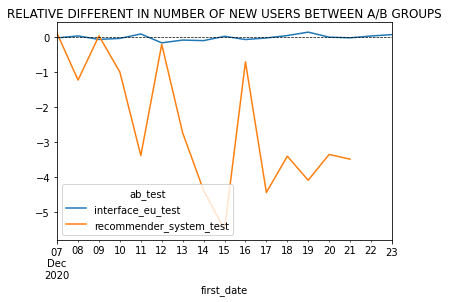

In [4]:
print('_'*10, 'CHECK A/B TEST WITH RECORDED TECHNICAL SPECIFICATION', '_'*10)
print()

# combine "test" and "users" dataframe
df = dfs['test'].merge(dfs['users'], on='user_id', how='left')

test_list = df['ab_test'].unique()
# loop through each test
for test in test_list:
    print('CHECK "{}"'.format(test.upper()))
    print()
    sample = df[df['ab_test']==test]

    print('+ Number of participated group for each user') # check for mixed group users
    check = Check_Unique(sample,'user_id','group')
    print()

    for col in ['group', 'region']: # check region and group distribution
        print('+ Proportion of "{}" data'.format(col))
        print(sample[col].value_counts(normalize=True))
        print()

    print('+ Distribution of "first_date" data') # check time range
    print(sample['first_date'].describe(datetime_is_numeric=True))

    Breakline()

# plot relative different in number of new users between groups
ax = df.groupby(['first_date', 'ab_test', 'group'])['user_id'].nunique().unstack(2).apply(lambda row: (row['B']-row['A'])/row['B'], axis=1).unstack(1).plot.line()
ax.set(title='RELATIVE DIFFERENT IN NUMBER OF NEW USERS BETWEEN A/B GROUPS')
ax.axhline(y=0, color='black', ls='--', lw=0.7)
plt.show()

# Part_2> EXPLORATORY DATA ANALYSIS <a id="part_2"></a>

### SUMMARY:


**DISTRIBUTION OF EVENTS**  

+ More events recorded near Christmas time.  
Tests overlapped with 'Christmas&New Year Promo' campaign in the last few days - after stop taking up new users.

+ **interface_eu_test**: proportion of `event_name` and `group` activity stable through time  

    **recommender_system_test**: proportion of `event_name` slightly less stable. Proportion of `group` events steadily shifted due to error in new users splitting.

+ Event data of the last date ('2020-12-30') is not complete.  

--- 

**EVENT STAGES FUNNEL**

+ ~65% users reach 'product_page' stage and ~30% users reach 'product_cart' and 'purchase' stage.  

+ Differences in conversion rate between A and B groups of both tests are not obvious.

--- 

**TIMELINE CONSIDERATION**  

+ Improve in 14-days conversion rate is expected in A/B test result.  
However, events data are only available for 7-9 days after stop taking new users.

+ To give all users equal time for conversion, less than 14 days new users needed to be removed (resulting in much smaller dataset) or shorter conversion time limit is used.

+ At least 99% of observed conversion happen within the first days for all event stages on both tests.  
=> 7-days conversion rate is chosen for A/B test result analysis

In [5]:
print('CREATE "EVENTS" DATAFRAME WITH SPECIFIC TEST GROUP INFORMATION')
print()

# get list of non mixed test users from EU
chosen_id = df[(df['region']=='EU') & (~df['user_id'].isin(mixed_test_users))]['user_id'].unique().tolist()
print('+ Number of non mixed test users from EU:', len(chosen_id))
print()

# get event of only chosen_id
events = dfs['events'][dfs['events']['user_id'].isin(chosen_id)].reindex()

# round "event_dt" to days
events['event_dt'] = events['event_dt'].astype('datetime64[D]') 

# merge "first_date" information
events = events.merge(dfs['users'][['user_id','first_date']], on='user_id', how='left')

# get test "group" information
for test in test_list: # merge test group to events dataframe
    events = events.merge(df[df['ab_test']==test][['user_id','group']], on='user_id', how='left').rename(columns={'group':test})

print(events.info())
display(events.drop(events.index[5:-5]))

CREATE "EVENTS" DATAFRAME WITH SPECIFIC TEST GROUP INFORMATION

+ Number of non mixed test users from EU: 12557

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90173 entries, 0 to 90172
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  90173 non-null  object        
 1   event_dt                 90173 non-null  datetime64[ns]
 2   event_name               90173 non-null  object        
 3   details                  13083 non-null  float64       
 4   first_date               90173 non-null  datetime64[ns]
 5   recommender_system_test  16959 non-null  object        
 6   interface_eu_test        73214 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 5.5+ MB
None


,user_id,event_dt,event_name,details,first_date,recommender_system_test,interface_eu_test
0,96F27A054B191457,2020-12-07,purchase,4.99,2020-12-07,NaN,B
1,831887FE7F2D6CBA,2020-12-07,purchase,4.99,2020-12-07,A,NaN
2,A92195E3CFB83DBD,2020-12-07,purchase,4.99,2020-12-07,NaN,A
3,354D653172FF2A2D,2020-12-07,purchase,4.99,2020-12-07,NaN,A
4,7FCD34F47C13A9AC,2020-12-07,purchase,9.99,2020-12-07,NaN,B
90168,75845C83258FBF73,2020-12-30,login,NaN,2020-12-07,B,NaN
90169,4584E51B99DE51AE,2020-12-30,login,NaN,2020-12-07,NaN,A
90170,9DF4F595A906A0BA,2020-12-30,login,NaN,2020-12-07,NaN,B
90171,6181F3835EBE66BF,2020-12-30,login,NaN,2020-12-07,NaN,A
90172,F80C9BDDEA02E53C,2020-12-30,login,NaN,2020-12-07,NaN,A


__________ "RECOMMENDER_SYSTEM_TEST" __________

+ Total number of events: 16959
+ Total number of users: 2594
+ Average number of events per user: 6.54



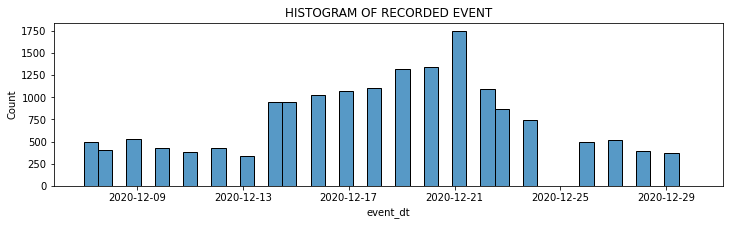

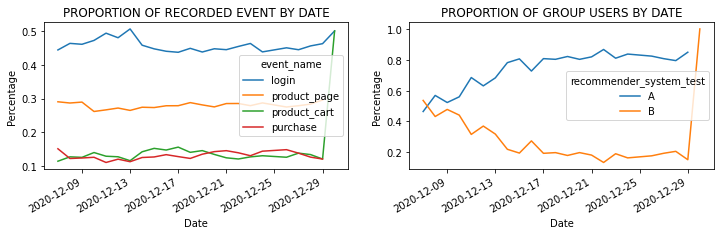

TIMELINE CONSIDERATION

+ "first_date" range: 2020-12-07 00:00:00 - 2020-12-21 00:00:00
+ Last "event_dt" recorded: 2020-12-30 00:00:00
+ Number of user active before "first_date" registered: 0 (0.0%)
+ Time gap between last "event_dt" and "first_date": 9 days 00:00:00

+ Distribution of conversion time for each event stage (recommender_system_test):


event_name,login,product_page,product_cart,purchase
count,2593,1632,773,804
mean,0 days 00:26:06.062475896,0 days 00:22:03.529411764,0 days 00:20:29.495472186,0 days 00:17:54.626865671
std,0 days 06:51:58.141154243,0 days 06:31:35.845889155,0 days 05:47:03.545844372,0 days 05:20:53.500672721
min,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
50%,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
99%,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
max,8 days 00:00:00,8 days 00:00:00,6 days 00:00:00,6 days 00:00:00



+ Overlapped marketing campaign:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07



----------------------------------------------------------------------------------------------------

__________ "INTERFACE_EU_TEST" __________

+ Total number of events: 73214
+ Total number of users: 9963
+ Average number of events per user: 7.35



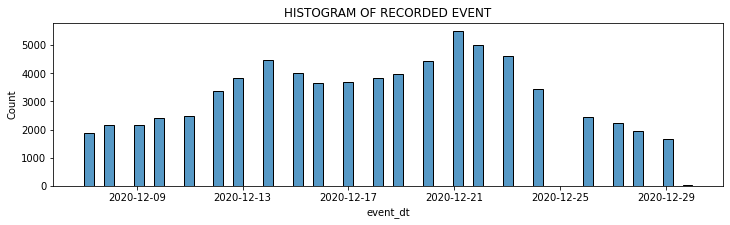

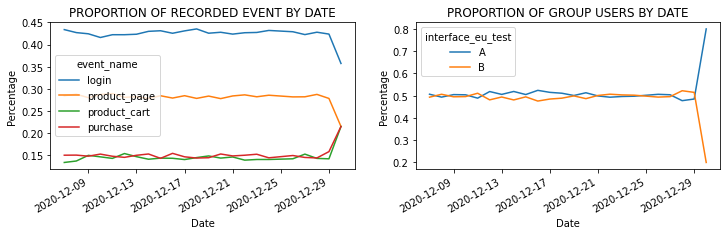

TIMELINE CONSIDERATION

+ "first_date" range: 2020-12-07 00:00:00 - 2020-12-23 00:00:00
+ Last "event_dt" recorded: 2020-12-30 00:00:00
+ Number of user active before "first_date" registered: 0 (0.0%)
+ Time gap between last "event_dt" and "first_date": 7 days 00:00:00

+ Distribution of conversion time for each event stage (interface_eu_test):


event_name,login,product_page,product_cart,purchase
count,9962,6620,3315,3435
mean,0 days 00:18:12.792611925,0 days 00:22:24.290030211,0 days 00:09:33.393665158,0 days 00:24:44.017467248
std,0 days 07:14:22.960193303,0 days 08:39:28.746607698,0 days 03:03:34.035229387,0 days 05:18:29.570586237
min,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
50%,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
99%,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
max,17 days 00:00:00,17 days 00:00:00,4 days 00:00:00,6 days 00:00:00



+ Overlapped marketing campaign:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07



----------------------------------------------------------------------------------------------------



In [6]:
event_list = ['login', 'product_page', 'product_cart', 'purchase']

for test in test_list:
    sample = events[(~events[test].isna())]

    print('_'*10, '"{}"'.format(test.upper()), '_'*10)
    print()

    # general information
    print('+ Total number of events:', len(sample))
    print('+ Total number of users:', sample['user_id'].nunique())
    print('+ Average number of events per user: {:.2f}'.format(len(sample)/sample['user_id'].nunique()))
    print()

    # plot histogram
    fig, ax = plt.subplots(figsize=(12,3))
    sns.histplot(data=sample, x='event_dt', ax=ax).set_title('HISTOGRAM OF RECORDED EVENT')
    plt.show()

    # plot proportion of events
    fig, ax = plt.subplots(ncols=2, figsize=(12,3))
    Pivot_Columns_Percentage(sample, index='event_dt', column='event_name', value='user_id',        aggfunc='count')[event_list].plot.line(ax=ax[0], title='PROPORTION OF RECORDED EVENT BY DATE')
    ax[0].set(ylabel='Percentage', xlabel='Date')

    # plot proportion of user group
    Pivot_Columns_Percentage(sample, index='event_dt', column=test, value='user_id', aggfunc='nunique').plot.line(ax=ax[1], title='PROPORTION OF GROUP USERS BY DATE')
    ax[1].set(ylabel='Percentage', xlabel='Date')
    plt.show()
    print()

    # graph funnel
    funnel = sample.groupby([test, 'event_name'])['user_id'].nunique().unstack(1)[event_list]
    fig = go.Figure()
    for group in ['A','B']:
        fig.add_trace(go.Funnel(name = 'group '+ group, y = event_list, x = funnel.loc[group],
                                textinfo = "value+percent initial"))
    fig.update_layout(title='NUMBER OF USERS AT EACH EVENT STAGES')
    fig.show()

    print('TIMELINE CONSIDERATION')
    print()
    t1 = sample['first_date'].min()
    t2 = sample['first_date'].max()
    t3 = sample['event_dt'].max()

    print('+ "first_date" range:', t1 , '-', t2)
    print('+ Last "event_dt" recorded:', t3)
    print('+ Number of user active before "first_date" registered:', Subset_Size(sample, sample['event_dt']<sample['first_date'], unique='user_id'))
    print('+ Time gap between last "event_dt" and "first_date":', t3 - t2)
    print()
    # check user converstion time distribution
    print('+ Distribution of conversion time for each event stage ({}):'.format(test))
    display(sample.groupby(['user_id','event_name']).apply(lambda row: row['event_dt'].min() - row['first_date'].min()).unstack(1)[event_list].describe([0.99],datetime_is_numeric=True))
    print()

    print('+ Overlapped marketing campaign:')
    display(dfs['campaign'][((dfs['campaign']['start_dt']>=t1) & (dfs['campaign']['start_dt']<=t3))
                        | ((dfs['campaign']['finish_dt']>=t1) & (dfs['campaign']['finish_dt']<=t3))])

    Breakline()

# Part_3> ANALYZE A/B TEST RESULTS <a id="part_3"></a>

### SUMMARY:

**recommender_system_test:** 7-days conversion to 'product_page' stage in group B is ~10% smaller than group A. The different is statistically significant.

**interface_eu_test:** 7-days conversion to 'purchase' stage in group B is smaller than group A. The different is small but statistically significant.

=> In all cases, no significant improvement in conversion rate in group B can be detected.



__________ COMPARE 7-DAYS CONVERSION BETWEEN A/B GROUPS OF "RECOMMENDER_SYSTEM_TEST" __________



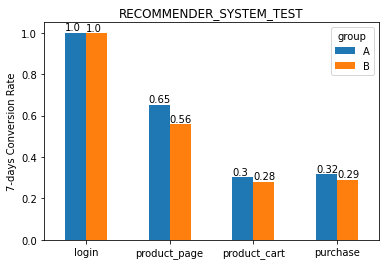

* With alpha level 0.05 :

"PRODUCT_PAGE" STAGE - pvalue 0.0000: We can  reject H0 hypothesis, the 7-days conversion rate of 2 groups are different.
"PRODUCT_CART" STAGE - pvalue 0.2690: We can not reject H0 hypothesis, the 7-days conversion rate of 2 groups could be the same.
"PURCHASE" STAGE - pvalue 0.2404: We can not reject H0 hypothesis, the 7-days conversion rate of 2 groups could be the same.

__________ COMPARE 7-DAYS CONVERSION BETWEEN A/B GROUPS OF "INTERFACE_EU_TEST" __________



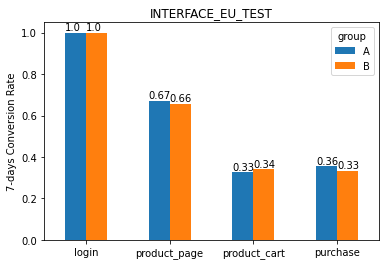

* With alpha level 0.05 :

"PRODUCT_PAGE" STAGE - pvalue 0.1475: We can not reject H0 hypothesis, the 7-days conversion rate of 2 groups could be the same.
"PRODUCT_CART" STAGE - pvalue 0.0917: We can not reject H0 hypothesis, the 7-days conversion rate of 2 groups could be the same.
"PURCHASE" STAGE - pvalue 0.0245: We can  reject H0 hypothesis, the 7-days conversion rate of 2 groups are different.



In [7]:
for test in test_list:
    ABTest_Analysis(test = test, lastdate = pd.to_datetime('2020-12-29'), delta = 7, alpha=0.05)
    print()

# Part_4> SUMMARY AND CONCLUSION <a id="part_4"></a>

### Analysis of two A/B tests with a lot of uncertainty:  

+ The **recommender_system_test** was poorly carried out on ~3000 users with imbalance group splitting.

+ The possibly alternative **interface_eu_test** was properly carried out on ~10000 users. The exact nature of the test is unclear.

### Disregard the uncertainty, no improvement in conversion rate was detected in all cases.

There are statistically significant reduction in conversion rate of group B for 'product_page' stage in **recommender_system_test** and 'purchase' stage in **interface_eu_test**

